In [1]:
import pandapower as pp #import pandapower
import numpy as np
import pandas as pd
import os
import random
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
from shapely.geometry import Point
from pandapower.estimation import estimate
import pandapower.plotting as plot

In [2]:
%run "C:/Users/13496/geoplot.ipynb"

In [3]:
length=min_distances

In [4]:
profiles = pd.read_csv('D:\\18 Battlefield Road substation\\data_30min_avg_1.csv', header=0, decimal=',')
profiles = profiles.dropna()
profiles = profiles.reset_index(drop=True)
profiles=profiles.iloc[:, 1:]
header = profiles.columns.tolist()
profiles = profiles.astype('float64')
profiles=profiles/1000
ds = DFData(profiles)

In [5]:
profiles_q = pd.read_csv('D:\\18 Battlefield Road substation\\data_q_30min_avg_1.csv', header=0, decimal=',')
profiles_q = profiles_q.dropna()
profiles_q = profiles_q.reset_index(drop=True)
profiles_q=profiles_q.iloc[:, 1:]
header_q = profiles_q.columns.tolist()
profiles_q = profiles_q.astype('float64')
profiles_q=profiles_q/1000
ds_q = DFData(profiles_q)

In [6]:
def creat_net(length,p,q,geo_primary,geo_secondary):
    net = pp.create_empty_network()

    # Create HV and LV transformer buses
    hv_bus = pp.create_bus(net, name="HV Transformer Bus",geodata=geo_primary[0], vn_kv=33, type="n")
    lv_bus = pp.create_bus(net, name="LV Transformer Bus",geodata=geo_primary[0], vn_kv=11, type="n")

    # Create additional 20 LV buses
    lv_buses = [pp.create_bus(net, name=f'LV Bus {i}', vn_kv=11,geodata=geo_secondary[i],type='b') for i in range(0, 20)]

    # Create the transformer to step down voltage from 33kV to 11kV
    pp.create_transformer_from_parameters(net, hv_bus, lv_bus, sn_mva=20, vn_hv_kv=33, vn_lv_kv=11, vkr_percent=0.06,
                                      vk_percent=8, pfe_kw=0, i0_percent=0, name='HV-LV-Trafo')
    
    test_type = {"r_ohm_per_km": 0.128, "x_ohm_per_km": 0.37, "c_nf_per_km": 0.2, "max_i_ka": 0.257, "type": "cs"}
    pp.create_std_type(net, name="test_type", data=test_type, element="line")
    for n in range(0,20):
        from_bus = lv_bus
        to_bus =  pp.get_element_index(net, "bus", name='LV Bus %s'% n)
        pp.create_line(net, from_bus, to_bus, length_km=length[n]/1000,std_type="test_type",name='LV Line %s'% n)
        bus_idx = pp.get_element_index(net, "bus", name='LV Bus %s'% n)
        pp.create_load(net, bus_idx, p_mw=p[n]/1000, q_mvar=q[n]/1000,name='LV Load %s'% n)
    # Create a slack bus
    pp.create_ext_grid(net, hv_bus) 

    
    
    return net

In [7]:
net=creat_net(length,profiles.iloc[0], profiles_q.iloc[0],coordinates_pri,coordinates_sec)

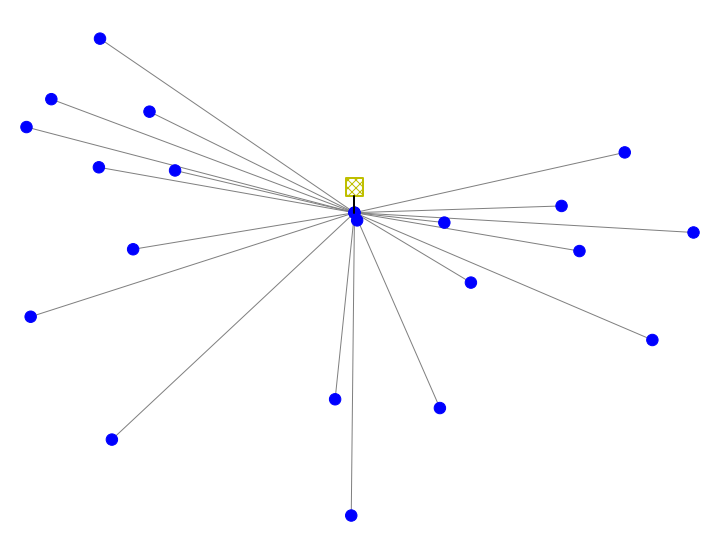

<AxesSubplot:>

In [8]:
plot.simple_plot(net)

In [9]:
for n in range(0,20):
    ConstControl(net, element='load', variable='p_mw', element_index=[n],
                 data_source=ds, profile_name=header[n])
    ConstControl(net, element='load', variable='q_mvar', element_index=[n],
                 data_source=ds_q, profile_name=header_q[n])

In [10]:
time_steps=1800
ow = OutputWriter(net, time_steps, output_path=os.path.join("time_series_example"), output_file_type=".xlsx", log_variables=list())
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')
ow.log_variable('res_line', 'i_ka')

In [11]:
run_timeseries(net, time_steps=time_steps)

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
100%|██████████| 30/30 [00:03<00:00,  7.85it/s]
